<a href="https://colab.research.google.com/github/ankurneo/EVA/blob/Assignment7/CIFAR_GradCam.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

1. The code such that it uses GPU and
2. The architecture to C1C2C3C40 (No MaxPooling, but 3 3x3 layers with stride of 2 instead) 
3. Total RF must be more than 44
4. One of the layers must use Depthwise Separable Convolution
5. One of the layers must use Dilated Convolution

**Note** -: use GAP (compulsory):- add FC after GAP to target #of classes (optional)

use albumentation library and apply:

a. Horizontal flip

b. ShiftScaleRotate

c. CoarseDropout (max_holes = 1, max_height=16px, max_width=1, min_holes = 1, min_height=16px, min_width=16px, fill_value=(mean of your dataset), mask_fill_value = None)


d. Achieve 85% accuracy, as many epochs as you want. Total Params to be less than 200k.

# Import Libraries

In [5]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torchvision import datasets, transforms
import albumentations as A
from albumentations.pytorch import ToTensorV2
import numpy as np 

In [6]:
class Cifar10SearchDataset(torchvision.datasets.CIFAR10):
    def __init__(self, root="~/data/cifar10", train=True, download=True, transform=None):

        super().__init__(root=root, train=train, download=download, transform=transform)

    def __getitem__(self, index):

        image, label = self.data[index], self.targets[index]

        if self.transform is not None:
            transformed = self.transform(image=image)
            image = transformed["image"]
        return image, label

class args():

    def __init__(self,device = 'cpu' ,use_cuda = False) -> None:

        self.batch_size = 128

        self.device = device

        self.use_cuda = use_cuda

        self.kwargs = {'num_workers': 1, 'pin_memory': True} if self.use_cuda else {}

## Data Transformations

We first start with defining our data transformations. We need to think what our data is and how can we augment it to correct represent images which it might not see otherwise. 


In [7]:
train_transforms = A.Compose(
    [
        A.HorizontalFlip(),
            A.RandomCrop(
               height=32,width=32,always_apply=True
            ),
            A.CoarseDropout(
                max_holes=1, max_height=16, 
                max_width=16
            ),
        A.Normalize(
            mean = (0.491, 0.482, 0.447),
            std = (0.247, 0.243, 0.262)           
        ),
        ToTensorV2()
    ]
)

test_transforms = A.Compose(
    [
        A.Normalize(
            mean = (0.491, 0.482, 0.447),
            std = (0.247, 0.243, 0.262)
        ),
        ToTensorV2()
    ]
)

# Dataset and Creating Train/Test Split

In [8]:
SEED = 1

# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

trainset = Cifar10SearchDataset(root='./data', train=True, download=True, transform=train_transforms)

testset = Cifar10SearchDataset(root='./data', train=False,download=True, transform=test_transforms)

CUDA Available? True


  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


# Dataloader Arguments & Test/Train Dataloaders


In [9]:
trainloader = torch.utils.data.DataLoader(trainset, batch_size=args().batch_size, shuffle=True, **args().kwargs)

testloader = torch.utils.data.DataLoader(testset, batch_size=args().batch_size, shuffle=False, **args().kwargs)     

classes = ('plane', 'car', 'bird', 'cat','deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Import Model

In [10]:
import torch
import torch.nn as nn
import torch.nn.functional as F


class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(
            in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out
   

class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=10):
        super(ResNet, self).__init__()
        self.in_planes = 64

        self.conv1 = nn.Conv2d(3, 64, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)
        self.linear = nn.Linear(512*block.expansion, num_classes)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = F.avg_pool2d(out, 4)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out


def ResNet18():
    return ResNet(BasicBlock, [2, 2, 2, 2])


def ResNet34():
    return ResNet(BasicBlock, [3, 4, 6, 3])


def test():
    net = ResNet18()
    y = net(torch.randn(1, 3, 32, 32))
    print(y.size())

# test()

#Creating instance of all the 3 Models by passing Normalization Type as a Parameter

In [11]:
!pip install torchsummary
from torchsummary import summary
#import model
#from model import Net
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model = ResNet18().to(device)
summary(model, input_size=(3, 32, 32))

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,728
       BatchNorm2d-2           [-1, 64, 32, 32]             128
            Conv2d-3           [-1, 64, 32, 32]          36,864
       BatchNorm2d-4           [-1, 64, 32, 32]             128
            Conv2d-5           [-1, 64, 32, 32]          36,864
       BatchNorm2d-6           [-1, 64, 32, 32]             128
        BasicBlock-7           [-1, 64, 32, 32]               0
            Conv2d-8           [-1, 64, 32, 32]          36,864
       BatchNorm2d-9           [-1, 64, 32, 32]             128
           Conv2d-10           [-1, 64, 32, 32]          36,864
      BatchNorm2d-11           [-1, 64, 32, 32]             128
       BasicBlock-12           [-1, 64, 32, 32]               0

# Training 
Let's write train function

In [12]:
def train(model, device, train_loader, optimizer, epoch, L1):
    model.train()
    epoch_loss = 0
    correct = 0

    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.cross_entropy(output, target)

        if L1:
          L1_loss = nn.L1Loss(size_average=None, reduce=None, reduction='mean')
          reg_loss = 0 
          for param in model.parameters():
            zero_vector = torch.rand_like(param) * 0
            reg_loss += L1_loss(param,zero_vector)
          loss += .001 * reg_loss

        epoch_loss += loss.item()
        loss.backward()
        optimizer.step()
        pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
        correct += pred.eq(target.view_as(pred)).sum().item()

    print(f'Train set: Average loss: {loss.item():.4f}, Accuracy: {100. * correct/len(train_loader.dataset):.2f}')
    train_loss = epoch_loss / len(train_loader)
    train_acc=100.*correct/len(train_loader.dataset)
    return train_loss, train_acc

# Testing
Let's write testing function

In [13]:
def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    test_pred = torch.LongTensor()
    target_pred = torch.LongTensor()
    target_data = torch.LongTensor()

    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.cross_entropy(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            pred_cpu = output.cpu().data.max(dim=1, keepdim=True)[1]
            correct += pred.eq(target.view_as(pred)).sum().item()
            test_pred = torch.cat((test_pred, pred_cpu), dim=0)
            target_pred = torch.cat((target_pred, target.cpu()), dim=0)
            target_data = torch.cat((target_data, data.cpu()), dim=0)


    test_loss /= len(test_loader.dataset)
    test_acc = 100.*correct/len(test_loader.dataset)
    print(f'\nTest set: Average loss: {test_loss:.3f}, Accuracy: {100. * correct/len(test_loader.dataset):.2f}')
    return test_loss, test_acc, test_pred, target_pred, target_data

# A main function calling test and train functions

#Input Params

*   EPOCHS
*   model
*   device
*   train_loader
*   test_loader
*   optimizer
*   L1 (Lasso Regression is true or false)

#OutPut Params
* train_loss_values
* test_loss_values
* train_acc_values
* test_acc_values
* test_pred
* target_pred
* target_data


In [14]:
def main(EPOCHS, model, device, train_loader, test_loader, optimizer, L1):
  train_loss_values = []
  test_loss_values = []
  train_acc_values = []
  test_acc_values = []

  for epoch in range(EPOCHS):
      print('\nEpoch {} : '.format(epoch))
      # train the model
      train_loss, train_acc = train(model, device, train_loader, optimizer, epoch, L1)
      test_loss, test_acc, test_pred, target_pred, target_data  = test(model, device, test_loader)

      train_loss_values.append(train_loss)
      test_loss_values.append(test_loss)

      train_acc_values.append(train_acc)
      test_acc_values.append(test_acc)

  return train_loss_values, test_loss_values, train_acc_values, test_acc_values, test_pred, target_pred, target_data

## Calling the Model with 75 Epochs

In [15]:
EPOCHS = 1
model =  ResNet18().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
criterion = nn.CrossEntropyLoss()
l1reg = False
train_loss, test_loss, train_acc, test_acc , test_pred, target_pred, target_data = main(EPOCHS, model, device, trainloader, testloader, optimizer, l1reg)



Epoch 0 : 
Train set: Average loss: 1.2687, Accuracy: 45.74

Test set: Average loss: 1.097, Accuracy: 60.75


In [1]:
import numpy as np
import matplotlib.pyplot as plt 

def plot_train_vs_test_accuracy(epochs, train_acc, test_acc):
  train_range = range(1,epochs+1)
  plt.plot(train_range, train_acc, 'g', label='Training accuracy')
  plt.plot(train_range, test_acc, 'b', label='validation accuracy')
  plt.title('Training and Validation accuracy')
  plt.xlabel('Epochs')
  plt.ylabel('Accuracy')
  plt.legend()
  plt.show()

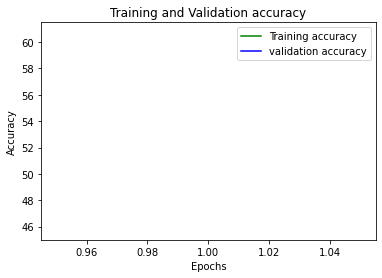

In [16]:
plot_train_vs_test_accuracy(EPOCHS, train_acc, test_acc)

In [17]:
def view_misclassified_images(model, device, dataset, classes):
  misclassified_images = []
  
  for images, labels in dataset:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            for i in range(len(labels)):
              if(len(misclassified_images)<20 and predicted[i]!=labels[i]):
                misclassified_images.append([images[i],predicted[i],labels[i]])
            if(len(misclassified_images)>20):
              break
    
  
  fig = plt.figure(figsize = (8,8))
  for i in range(20):
        sub = fig.add_subplot(5, 5, i+1)
        #imshow(misclassified_images[i][0].cpu())
        img = misclassified_images[i][0].cpu()
        img = img / 2 + 0.5 
        npimg = img.numpy()
        plt.imshow(np.transpose(npimg,(1, 2, 0)),interpolation='none')
        
        sub.set_title("P={}, A={}".format(str(classes[misclassified_images[i][1].data.cpu().numpy()]),str(classes[misclassified_images[i][2].data.cpu().numpy()])))
        
  plt.tight_layout()
  return misclassified_images   

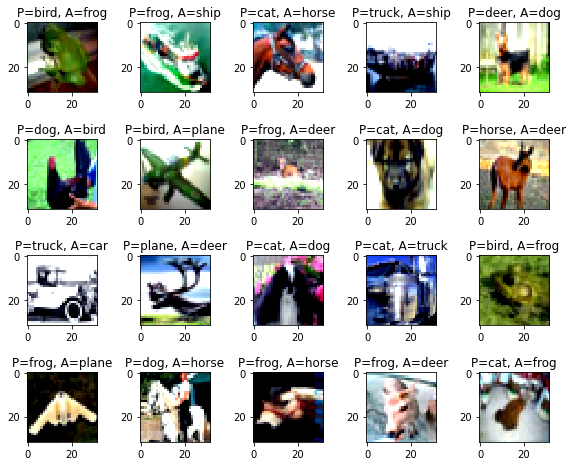

In [18]:
misclassified_images = view_misclassified_images(model, device, testloader, classes)

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/jacobgil/pytorch-grad-cam.git to /tmp/pip-req-build-2l5io2cn
  Running command git clone --filter=blob:none --quiet https://github.com/jacobgil/pytorch-grad-cam.git /tmp/pip-req-build-2l5io2cn
  Resolved https://github.com/jacobgil/pytorch-grad-cam.git to commit 2183a9cbc1bd5fc1d8e134b4f3318c3b6db5671f
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
Prediction is truck
Label is car


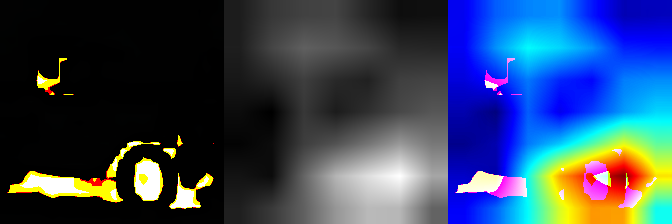

In [49]:
#https://jacobgil.github.io/pytorch-gradcam-book/CAM%20Metrics%20And%20Tuning%20Tutorial.html
#https://www.kaggle.com/code/antwerp/where-is-the-model-looking-for-gradcam-pytorch/notebook
!pip install git+https://github.com/jacobgil/pytorch-grad-cam.git

import warnings
warnings.filterwarnings('ignore')
from torchvision import models
import numpy as np
import cv2
import requests
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image, \
    deprocess_image, \
    preprocess_image
from PIL import Image

#model = models.resnet18(pretrained=True)
#model.eval()
#image_url = "https://th.bing.com/th/id/R.94b33a074b9ceeb27b1c7fba0f66db74?rik=wN27mvigyFlXGg&riu=http%3a%2f%2fimages5.fanpop.com%2fimage%2fphotos%2f31400000%2fBear-Wallpaper-bears-31446777-1600-1200.jpg&ehk=oD0JPpRVTZZ6yizZtGQtnsBGK2pAap2xv3sU3A4bIMc%3d&risl=&pid=ImgRaw&r=0"
#img = np.array(Image.open(requests.get(image_url, stream=True).raw))
k=10
prediction = misclassified_images[k][1].data.cpu().numpy()
label = misclassified_images[k][2].data.cpu().numpy()
print("Prediction is", classes[prediction])
print("Label is", classes[label])
img = misclassified_images[k][0].data.permute(1, 2, 0).cpu().numpy()
img = cv2.resize(img, (224, 224))
img = np.float32(img) / 255
input_tensor = preprocess_image(img, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

# The target for the CAM is the Bear category.
# As usual for classication, the target is the logit output
# before softmax, for that category.
targets = [ClassifierOutputTarget(label)]
target_layers = [model.layer4]
with GradCAM(model=model, target_layers=target_layers) as cam:
    grayscale_cams = cam(input_tensor=input_tensor, targets=targets)
    cam_image = show_cam_on_image(img, grayscale_cams[0, :], use_rgb=True)
cam = np.uint8(255*grayscale_cams[0, :])
cam = cv2.merge([cam, cam, cam])
images = np.hstack((np.uint8(255*img), cam , cam_image))
Image.fromarray(images)